<a href="https://colab.research.google.com/github/khann160102/AIP391-SU2022/blob/main/LSTM_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul  5 02:13:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 13.6 gigabytes of available RAM



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras import Sequential
from keras.backend import clear_session
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, InputLayer, Dense, Dropout
from keras.losses import BinaryFocalCrossentropy
from keras.metrics import BinaryIoU
from keras.models import load_model

from tensorflow import data
from tensorflow.train import latest_checkpoint
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random

In [ ]:
path = '/content/drive/My Drive/Study Documents/FPTU/2022 Summer/AIP391/Final Data/'
input = 'features/'
output = 'label_raw/'

checkpoint_path = "/content/drive/My Drive/Study Documents/FPTU/2022 Summer/AIP391/Model/weights/cp-{epoch:03d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

plot_path = '/content/drive/My Drive/Study Documents/FPTU/2022 Summer/AIP391/Model/plot'

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

url_list = pd.read_csv(os.path.join(path,'url_list.csv'))['url'].to_numpy(dtype=str)

In [ ]:
# return a tensorflow tensor from given csv
# url_path (str): list of csv file path
# test (bool): Load test or train/val
def csv_to_tensor(url_path, test=False):
    sub_dataset = []
    i = 0
    if test:
      for inp in url_path:
        dfi = pd.read_csv(inp)
        dsi = data.Dataset.from_tensor_slices(dfi)
        ds = dsi.batch(len(dfi))
        sub_dataset.append(ds)
    else:
      for inp, out in url_path:
        dfi = pd.read_csv(inp)
        dfo = pd.read_csv(out)
        dsi = data.Dataset.from_tensor_slices(dfi)
        dso = data.Dataset.from_tensor_slices(dfo)
        assert len(dfi) == len(dfo)
        ds = data.Dataset.zip((dsi, dso)).batch(len(dfi))
        sub_dataset.append(ds)

    tensor = sub_dataset[0]
    for dataset in sub_dataset[1:]:
        tensor = tensor.concatenate(dataset)
    return tensor

In [ ]:
# return train/val dataset and length of test size in tuple
# take (int): number of total video want to use
# size (tuple): portion of each dataset size (summ = 1)
def load_dataset(take=1406, size=(.8, .15, .05), test=False):
    train_size = int(size[0]*take)
    val_size = int(size[1]*take)
    test_size = take - train_size - val_size
    rest = random.sample(list(url_list[test:]), take - test)

    if not test:
      train_path = rest[val_size:]
      train = csv_to_tensor([(os.path.join(path,input,x),
                                os.path.join(path,output,x)) for x in train_path])
      val_path = rest[:val_size]
      val = csv_to_tensor([(os.path.join(path,input,x),
                               os.path.join(path,output,x))for x in val_path])
      return train, val
    else:
      test_path = url_list[:test]
      test = csv_to_tensor([os.path.join(path,input,x) for x in test_path], test=True)
      return test, test_path

In [ ]:
def merge_k(predict, threshold=0.5, k=5):
  i = count = start = 0
  while i < len(predict):
    if predict[i] < threshold and predict[i-1] >= threshold:
      j = i
      while j+1 < len(predict) and predict[j+1] < threshold:
        j += 1
      if j-i < k and j+1 < len(predict) - 1:
        predict[i:j+1] = 1
      i = j
    i += 1
  return predict

In [ ]:
def predict_to_csv(pred_path, threshold=0.5, model=None, test=None, test_l=[]):
  if not os.path.exists(os.path.join(pred_path)):
    os.makedirs(os.path.join(pred_path))
  for i, url in enumerate(test_l):
    data = test.skip(i).batch(1).take(1)
    predict = np.squeeze(model.predict(data))
    pd.DataFrame(data=predict).to_csv(os.path.join(pred_path,url), index=False)

In [ ]:
def IOU(pred_path, threshold=0.5, test_l=[]):
  res = []
  for url in test_l:
    label = merge_k(np.array(pd.read_csv(os.path.join(path,'label_raw',url)), dtype=float), threshold=threshold)
    predict = merge_k(np.array(pd.read_csv(os.path.join(pred_path,url)), dtype=float), threshold=threshold)

    m = BinaryIoU(target_class_ids=[1], threshold=threshold)
    m.update_state(label, predict)
    iou = m.result().numpy()
    
    res.append(iou)
  return np.mean(res)

In [ ]:
def history_plot(history=[], k=0, save=False, plot_path=''):
  k=str(k)
  if save and not os.path.exists(os.path.join(plot_path, str(k))):
    os.makedirs(os.path.join(plot_path, str(k)))
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss with k = ' + k)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='lower left')
  if save:
    plt.savefig(os.path.join(plot_path, k, 'loss.png'))
    plt.clf()
  else:
    plt.show()
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy with k = ' + k)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  if save:
    plt.savefig(os.path.join(plot_path, str(k), 'accuracy.png'))
    plt.clf()
  else:
    plt.show()
  # summarize history for IoU
  plt.plot(history.history['binary_io_u'])
  plt.plot(history.history['val_binary_io_u'])
  plt.title('Model IoU with k = ' + k)
  plt.ylabel('IoU')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  if save:
    plt.savefig(os.path.join(plot_path, k, 'iou.png'))
    plt.clf()
  else:
    plt.show()

In [ ]:
def main(k=5, take=1406, threshold=0.5, patience=10, checkpoint=False):
  print('Data importing...', end='')
  train, val = load_dataset(take=take, size=(.8,.15,.05))
  print('\rData imported!', ' '*10)
  
  print('Model initializing...', end='')
  clear_session()
  model = Sequential(name='food_frame_classification')
  model.add(InputLayer(input_shape=(None, 512)))
  model.add(LSTM(64, return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(64, return_sequences=True))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  print('\rModel initialized!', ' '*10)

  print('Model compiling...', end='')
  model.compile(loss=BinaryFocalCrossentropy(gamma=5.0,label_smoothing=0.9),
                optimizer='adam',
                metrics=['accuracy',BinaryIoU(target_class_ids=[1], threshold=threshold)],
                run_eagerly=True)
  latest = latest_checkpoint(checkpoint_dir)
  model.load_weights(latest)
  print('\rModel compiled!', ' '*10)

  print('Model training...')
  es = EarlyStopping(monitor='val_binary_io_u',
                     mode='max',
                     min_delta=0.01,
                     restore_best_weights=True,
                     patience=patience)
  cp = ModelCheckpoint(filepath=checkpoint_path,
                       monitor='val_binary_io_u',
                       save_best_only=True,
                       save_weights_only=True)
  callbacks = [cp, es] if checkpoint else [es]
  history = model.fit(train.batch(1).prefetch(data.AUTOTUNE),
                      validation_data=val.batch(1).prefetch(data.AUTOTUNE),
                      epochs=100,
                      callbacks=callbacks)
  print('\rModel training completed!', ' '*10)

  pred_path = os.path.join(path,'predict',str(k))
  predict_to_csv(pred_path, threshold=0.5, model=model, test=test, test_l=test_path)
  print('Evaluating...', end='')
  mean = IOU(pred_path, threshold=threshold, test_l=test_path)*100
  print('\rEvaluated!', ' '*10)
  print("Prediction's mean IoU:", str(mean) + '%')

  return history, mean, k

In [ ]:
print('Start run:', end=' ')
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Asia/Bangkok /etc/localtime
!date

Start run: Tue Jul  5 02:13:54 +07 2022


In [ ]:
take = 1406 # ALL VIDEOS TAKEN
print('Data importing...', end='')
test, test_path = load_dataset(take=take, size=(.8,.15,.05), test=True)
print('\rData imported!', ' '*10)

Data imported!           


In [ ]:
history = main(k=0, take=take, threshold=0.5, patience=20, checkpoint=True)[0]

Data imported!           
Model initialized!           
Model compiled!           
Model training...
Epoch 1/100
1196/1196 [==============================] - 90s 72ms/step - loss: 0.0211 - accuracy: 0.7419 - binary_io_u: 0.0179 - val_loss: 0.0210 - val_accuracy: 0.7113 - val_binary_io_u: 7.2024e-04
Epoch 2/100
1196/1196 [==============================] - 86s 72ms/step - loss: 0.0209 - accuracy: 0.7483 - binary_io_u: 0.0394 - val_loss: 0.0209 - val_accuracy: 0.7112 - val_binary_io_u: 9.7679e-04
Epoch 3/100
1196/1196 [==============================] - 86s 72ms/step - loss: 0.0208 - accuracy: 0.7548 - binary_io_u: 0.1226 - val_loss: 0.0209 - val_accuracy: 0.7125 - val_binary_io_u: 0.0085
Epoch 4/100
1196/1196 [==============================] - 87s 73ms/step - loss: 0.0206 - accuracy: 0.7712 - binary_io_u: 0.2293 - val_loss: 0.0209 - val_accuracy: 0.7124 - val_binary_io_u: 0.0197
Epoch 5/100
1196/1196 [==============================] - 88s 73ms/step - loss: 0.0205 - accuracy: 0.7902 - bina

In [ ]:
history_plot(history, 'init', save=True, plot_path=plot_path)

<Figure size 432x288 with 0 Axes>

In [ ]:
iou = []
for i in range(11):
  print('NOW i =', i)
  iou.append(main(k=i, take=take, threshold=0.5, patience=10))
  print('\n')

NOW i = 0
Data imported!           
Model initialized!           
Model compiled!           
Model training...
Epoch 1/100
1196/1196 [==============================] - 89s 74ms/step - loss: 0.0209 - accuracy: 0.7363 - binary_io_u: 0.0354 - val_loss: 0.0208 - val_accuracy: 0.7873 - val_binary_io_u: 0.0150
Epoch 2/100
1196/1196 [==============================] - 88s 74ms/step - loss: 0.0208 - accuracy: 0.7453 - binary_io_u: 0.1152 - val_loss: 0.0208 - val_accuracy: 0.7803 - val_binary_io_u: 0.1042
Epoch 3/100
1196/1196 [==============================] - 90s 75ms/step - loss: 0.0207 - accuracy: 0.7609 - binary_io_u: 0.2235 - val_loss: 0.0208 - val_accuracy: 0.7726 - val_binary_io_u: 0.1975
Epoch 4/100
1196/1196 [==============================] - 89s 74ms/step - loss: 0.0205 - accuracy: 0.7827 - binary_io_u: 0.3173 - val_loss: 0.0209 - val_accuracy: 0.7713 - val_binary_io_u: 0.2366
Epoch 5/100
1196/1196 [==============================] - 89s 74ms/step - loss: 0.0203 - accuracy: 0.8013 - bi

In [ ]:
print("Tests's IoU per k")
for i in range(len(iou)):
  print('k = %02d'%(i), '| Mean IoU:', str(round(iou[i][1], 5)) + '%')
  history_plot(iou[i][0], iou[i][2], save=True, plot_path=plot_path)

iou.sort(key=lambda row: (row[1]), reverse=True)

Tests's IoU per k
k = 00 | Mean IoU: 85.11211%
k = 01 | Mean IoU: 87.04566%
k = 02 | Mean IoU: 89.25542%
k = 03 | Mean IoU: 89.43466%
k = 04 | Mean IoU: 88.33172%
k = 05 | Mean IoU: 78.38565%
k = 06 | Mean IoU: 82.69581%
k = 07 | Mean IoU: 86.63677%
k = 08 | Mean IoU: 92.91045%
k = 09 | Mean IoU: 83.31797%
k = 10 | Mean IoU: 89.44044%


<Figure size 432x288 with 0 Axes>

Best result: k = 8


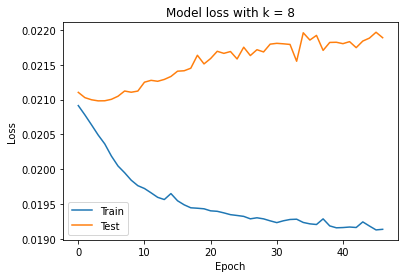

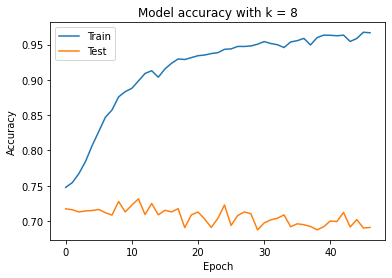

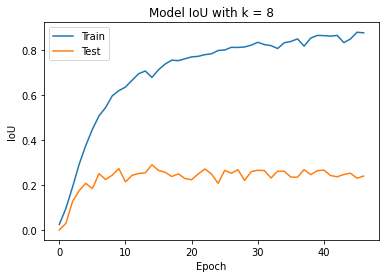

In [ ]:
print('Best result: k =', iou[0][2])
history_plot(iou[0][0], iou[0][2])

In [ ]:
print('End run:', end=' ')
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Asia/Bangkok /etc/localtime
!date

End run: Tue Jul  5 20:04:12 +07 2022
